In [1]:
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import decimate
import sys
import os
import glob
from tqdm import tqdm
sys.path.append(os.path.abspath("../.."))
import openpyxl
from sklearn.preprocessing import OneHotEncoder
from multiprocessing import Pool
from umap import UMAP
from pathlib import Path
from preprocessing.features.its_compressibility import compute_its_compressibility
from utils.audio_io import load_audio
from utils.plot_utils import plot_takens_embedding, plot_winding_xy
from preprocessing.signal_processing.preprocessing import preprocess_signal, prepare_signal
from preprocessing.features.winding import get_winding_curve
from preprocessing.signal_processing.fourier import apply_fft, get_dominant_frequencies
from preprocessing.features.its import extract_its
from preprocessing.features.features_extractor import extract_features_from_segmented_signal
# from preprocessing.features.mfcc import extract_mfcc_features
# from preprocessing.features.wavelet import  extract_wavelet_features
from preprocessing.segment_signal import segment_signal
from preprocessing.features.takens_rqa import extract_rqa_features
%matplotlib inline

## Rascunhos

### Arquivo de áudio

In [6]:
nome_do_arquivo = "../../data/raw/HeartANDLung_Sounds_Dataset/Mix/Mix/M0006.wav"
file_id = os.path.basename(nome_do_arquivo).replace(".wav", "")



### Carregando o arquivo de áudio
* fs ==> taxa de amostragem
* signal ==> vetor de amostras

In [7]:
fs, signal = load_audio(
    nome_do_arquivo)

### Iniciando a pré-filtragem/pré-processamento do sinal
A função `preprocess_signal` faz aplica:
* normalização do sinal
* Filtro passa-banda
* Filtro Binominal ou Filtro de Kalman

In [ ]:
signal, fs = prepare_signal(signal, fs, max_audio_duration=5, decimation_factor=10, use_kalman=True)

In [ ]:
df_topologico = extract_features_from_segmented_signal(
    signal=signal,
    fs=fs,
    file_id=nome_do_arquivo,
    extract_its_fn=extract_its,
    fft_fn=apply_fft,
    get_dom_freqs_fn=get_dominant_frequencies,
    extract_mfcc_fn=extract_mfcc_features,
    extract_wavelet_fn=extract_wavelet_features,
    extract_rqa_fn=extract_rqa_features,
    window_duration_sec=1.0,
    overlap=0.2,
    threshold=0.5,
    winding_duration=1.0,
    n_mfcc=13
)

c:\Users\pflss\miniconda3\envs\sensory-translation\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=400
  warnings.warn(


##### Gerando a primeira versão da base de dados após as técnicas de processamento de sinais 

Informações Topológicas Estruturadas dos dados brutos:

In [10]:
nome = os.path.basename(nome_do_arquivo).replace(".wav", "")
df_topologico.to_excel(f"../../datasets/raw/{nome}_features.xlsx", index=False)

In [11]:
""" 
Tratando os missing values em colunas RQA à priori
"""

# Substituir NaN por -1 somente em colunas RQA
rqa_cols = [col for col in df_topologico.columns if col.startswith(
    "rqa_") and df_topologico[col].isna().any()]
df_topologico[rqa_cols] = df_topologico[rqa_cols].fillna(-1)
# Criar flag binária
df_topologico["has_trapping"] = (
    df_topologico["rqa_trapping_time"] != -1).astype(int)

In [52]:
df_topologico.columns

Index(['freq', 'centro_x', 'centro_y', 'raio_medio', 'raio_std', 'raio_max',
       'raio_min', 'simetria_x', 'simetria_y', 'densidade_nucleo',
       'comprimento_curva', 'variacao_curvatura', 'mudanca_media_direcao',
       'entropia_raio', 'auto_intersecoes', 'file_id', 'window_id', 'mfcc_0',
       'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
       'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'wave_L0_mean',
       'wave_L0_std', 'wave_L0_energy', 'wave_D1_mean', 'wave_D1_std',
       'wave_D1_energy', 'wave_D2_mean', 'wave_D2_std', 'wave_D2_energy',
       'wave_D3_mean', 'wave_D3_std', 'wave_D3_energy', 'wave_D4_mean',
       'wave_D4_std', 'wave_D4_energy', 'wave_D5_mean', 'wave_D5_std',
       'wave_D5_energy', 'rqa_recurrence_rate', 'rqa_determinism',
       'rqa_average_diagonal_line', 'rqa_longest_diagonal_line',
       'rqa_entropy_diagonal_lines', 'rqa_laminarity', 'rqa_trapping_time',
       'rqa_longest_vertical_line', 'rqa_entropy_verti

In [53]:
df_mix.columns

Index(['Gender', 'Heart Sound Type', 'Lung Sound Type', 'Location',
       'Heart Sound ID', 'Lung Sound ID', 'Mixed Sound ID'],
      dtype='object')

In [54]:
# Filtrar apenas o registro H0001
meta = df_mix[df_mix['Heart Sound ID'] == 'H0001'].iloc[0]

In [25]:
meta

Gender                                 F
Heart Sound Type    Late Systolic Murmur
Lung Sound Type                  Rhonchi
Location                            LUSB
Heart Sound ID                     H0001
Lung Sound ID                      L0001
Mixed Sound ID                     M0001
Name: 0, dtype: object

In [55]:
for col in meta.index:
    df_topologico[col] = meta[col]
del df_topologico['Heart Sound ID']
del df_topologico['Lung Sound ID']
del df_topologico['Mixed Sound ID']

In [56]:
df_topologico

,freq,centro_x,centro_y,raio_medio,raio_std,raio_max,raio_min,simetria_x,simetria_y,densidade_nucleo,...,rqa_window_id,rqa_fs,rqa_embedding_dim,rqa_delay,rqa_rqa_threshold,has_trapping,Gender,Heart Sound Type,Lung Sound Type,Location
0,42.0,0.001237,-0.007288,0.035438,0.031405,0.309532,0.001473,0.030659,0.035859,0.8800,...,0,400,3,1,0.1,1,F,Late Systolic Murmur,Rhonchi,LUSB
1,47.0,0.003466,-0.012741,0.034761,0.030234,0.303880,0.001049,0.034996,0.032057,0.8925,...,0,400,3,1,0.1,1,F,Late Systolic Murmur,Rhonchi,LUSB
2,48.0,0.007011,0.000345,0.034934,0.032049,0.310102,0.000420,0.035166,0.031523,0.8900,...,0,400,3,1,0.1,1,F,Late Systolic Murmur,Rhonchi,LUSB
3,57.0,0.000101,-0.006924,0.035012,0.031983,0.309497,0.000551,0.035351,0.032580,0.8800,...,0,400,3,1,0.1,1,F,Late Systolic Murmur,Rhonchi,LUSB
4,31.0,0.000851,0.006500,0.028409,0.020670,0.116779,0.002178,0.023803,0.022399,0.5000,...,1,400,3,1,0.1,0,F,Late Systolic Murmur,Rhonchi,LUSB
5,33.0,-0.002164,-0.007188,0.028259,0.020553,0.108949,0.000871,0.022787,0.023516,0.4650,...,1,400,3,1,0.1,0,F,Late Systolic Murmur,Rhonchi,LUSB
6,35.0,-0.000919,-0.005589,0.028202,0.021211,0.112060,0.000749,0.023266,0.022920,0.4850,...,1,400,3,1,0.1,0,F,Late Systolic Murmur,Rhonchi,LUSB
7,37.0,-0.000453,0.009429,0.028362,0.019592,0.112353,0.001785,0.023728,0.023499,0.4750,...,1,400,3,1,0.1,0,F,Late Systolic Murmur,Rhonchi,LUSB
8,44.0,-0.001915,-0.004655,0.028336,0.021192,0.118595,0.001343,0.024070,0.024345,0.4975,...,1,400,3,1,0.1,0,F,Late Systolic Murmur,Rhonchi,LUSB
9,49.0,-0.001378,0.008902,0.028331,0.019838,0.109047,0.000156,0.024621,0.024263,0.4350,...,1,400,3,1,0.1,0,F,Late Systolic Murmur,Rhonchi,LUSB


### One-hot encoding

In [58]:
categorical = df_topologico[['Heart Sound Type', 'Lung Sound Type', 'Location', 'Gender']]
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(categorical)
cols = encoder.get_feature_names_out(['Heart Sound Type', 'Lung Sound Type', 'Location', 'Gender'])
df_encoded = pd.DataFrame(encoded, columns=cols)

In [ ]:
# Concatena com outros dados se necessário
df_final = pd.concat(
    [df_topologico.drop(categorical.columns, axis=1), df_encoded], axis=1)

In [60]:
df_final.to_excel(f"../../datasets/intermediate/{nome}_features.xlsx", index=False)

# **Geração do Dataset cru**
### Nesta etapa, geramos o dataset "cru", i.e. , a base de dados pronta e que antecede as etapas de exploração e pré-processamento propriamente dito. Neste caso, estamos apenas preparando os dados.

In [2]:
# CAMINHOS DOS RÓTULOS
df_rotulos_mix = pd.read_csv(
    '../../data/raw/HeartANDLung_Sounds_Dataset/Mix.csv', sep=';')
df_rotulos_hs = pd.read_csv(
    '../../data/raw/HeartANDLung_Sounds_Dataset/HS.csv', sep=',')
df_rotulos_ls = pd.read_csv(
    '../../data/raw/HeartANDLung_Sounds_Dataset/LS.csv', sep=';')

# CAMINHOS DOS ARQUIVOS DE ÁUDIO
arquivos_mix = "../../data/raw/HeartANDLung_Sounds_Dataset/Mix/Mix/M*.wav"
arquivos_hs_fromMix = "../../data/raw/HeartANDLung_Sounds_Dataset/Mix/Mix/H*.wav"
arquivos_ls_fromMix = "../../data/raw/HeartANDLung_Sounds_Dataset/Mix/Mix/L*.wav"

arquivos_HS = "../../data/raw/HeartANDLung_Sounds_Dataset/HS/HS/*.wav"
arquivos_LS = "../../data/raw/HeartANDLung_Sounds_Dataset/LS/LS/*.wav"

In [3]:
def extrair_features_topologicas(wav_path):
     """
     Aplica FFT, ITS, RQA e outras extrações sobre um .wav e retorna um DataFrame por janela.
     """
     fs, signal = load_audio(wav_path) 

     signal, fs = prepare_signal(
         signal, fs, max_audio_duration=15, decimation_factor=5, use_kalman=True)

     df_topologico = extract_features_from_segmented_signal(
          signal=signal,
          fs=fs,
         file_id=wav_path,
          extract_its_fn=extract_its,
          fft_fn=apply_fft,
          get_dom_freqs_fn=get_dominant_frequencies,
          #extract_mfcc_fn=extract_mfcc_features,
          #extract_wavelet_fn=extract_wavelet_features,
          extract_rqa_fn=extract_rqa_features,
         window_duration_sec=5.0,
          overlap=0.5,
          threshold=0.5,
         winding_duration=2.0
          #n_mfcc=13
          )
     """ 
     Tratando os missing values em colunas RQA à priori
     """

     # Substituir NaN por -1 somente em colunas RQA
     rqa_cols = [col for col in df_topologico.columns if col.startswith(
     "rqa_") and df_topologico[col].isna().any()]
     df_topologico[rqa_cols] = df_topologico[rqa_cols].fillna(-1)
     # Criar flag binária
     df_topologico["has_trapping"] = (
     df_topologico["rqa_trapping_time"] != -1).astype(int)
          
     return df_topologico

In [7]:
def calcular_num_janelas(fs, duration, window_duration_sec, overlap):
     total_samples = float(fs * duration)
     window_size = float(window_duration_sec * fs)
     hop_size = float(window_size * (1 - overlap))
     return (total_samples - window_size) // hop_size + 1


# Exemplo
decimation_factor = 5
fs = 44100 // decimation_factor
print(calcular_num_janelas(fs, 15.0, 4, 0.4))

5.0


In [40]:
def extrair_todas_as_features(wav_path, mix_df , id_column_name):
     """
     Processa 1 arquivo wav e retorna um DataFrame com features + rótulos.
     """
     base_id = os.path.basename(wav_path).replace('.wav', '')
     df_feat = extrair_features_topologicas(wav_path)

     # Pegando os metadados
     meta = mix_df[mix_df[id_column_name] == base_id].iloc[0]
     for col in meta.index:
          df_feat[col] = meta[col]

     return df_feat

In [48]:

# teste_features_mix = extrair_todas_as_features(
#     "../../data/raw/HeartANDLung_Sounds_Dataset/Mix/Mix_teste/M0006.wav", df_rotulos_mix, 'Mixed Sound ID')

# teste_features_hs = extrair_todas_as_features(
#     "../../data/raw/HeartANDLung_Sounds_Dataset/HS/HS/F_AF_A.wav", df_rotulos_hs, 'Heart Sound ID')

#### Função que gera o dataset consolidado ainda sem decodificação

In [41]:
def create_initial_dataset(path_audio_files: str, df_rotulos: pd.DataFrame, id_column_name: str):
    arquivos = sorted(glob.glob(path_audio_files))
    dfs = []
    for path in tqdm(arquivos):
        try:
            df = extrair_todas_as_features(path, df_rotulos, id_column_name)
            dfs.append(df)
        except Exception as e:
            print(f"Erro no {path}: {e}")
    
    df_final = pd.concat(dfs, ignore_index=True)
    
    return df_final

##### função para decodificação one-hot

In [42]:
def remove_columns(df: pd.DataFrame, columns_to_remove: list):
    return df.drop(columns=columns_to_remove)

In [43]:

def create_one_hot_encoded_df(df: pd.DataFrame, tipo: str) -> pd.DataFrame:
    """
    Codifica apenas as colunas categóricas relevantes:
    - LS: 'Gender', 'Location' (ignora 'Heart Sound Type')
    - HS: 'Gender', 'Location' (ignora 'Lung Sound Type')
    - Mix: 'Gender', 'Heart Sound Type', 'Lung Sound Type', 'Location'
    """
    df = remove_columns(df, ['file_id', 'rqa_file_id', 'rqa_window_id'])
    
    colunas_para_codificar = ['Gender', 'Heart Sound Type', 'Lung Sound Type', 'Location']
    
    # Define colunas específicas para cada tipo
    if tipo.upper() == "HS":
        colunas_para_codificar.remove("Lung Sound Type")
        del df['Heart Sound ID']
    elif tipo.upper() == "LS":
        colunas_para_codificar.remove("Heart Sound Type")
        del df['Lung Sound ID']
    else:
        if tipo.upper() != "MIX":
            raise ValueError(f"Tipo inválido: {tipo}. Use 'HS', 'LS' ou 'Mix'.")
        df.drop(columns=["Heart Sound ID", "Lung Sound ID"])

    # Verifica quais colunas realmente existem no DataFrame
    colunas_existentes = [
        col for col in colunas_para_codificar if col in df.columns]

    if not colunas_existentes:
        print("Nenhuma coluna categórica válida encontrada para codificação.")
        return df

    # Codifica apenas as colunas permitidas
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoded = encoder.fit_transform(df[colunas_existentes])

    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(
        colunas_existentes), index=df.index)

    # Junta com o DataFrame original (removendo só as colunas codificadas)
    df_final = pd.concat(
        [df.drop(columns=colunas_existentes), encoded_df], axis=1)

    return df_final

### Criando os datasets iniciais sem codificação

In [44]:
df_sem_cod_LS_fromMix = create_initial_dataset(arquivos_ls_fromMix, df_rotulos_mix, "Lung Sound ID")
df_sem_cod_LS_fromMix.to_csv("../../datasets/intermediate/dataset_semCodificacao_LSFromMix.csv", index=False)

100%|██████████| 145/145 [2:29:04<00:00, 61.68s/it]  


In [45]:
df_sem_cod_HS_fromMix = create_initial_dataset(arquivos_hs_fromMix, df_rotulos_mix, "Heart Sound ID")
df_sem_cod_HS_fromMix.to_csv(

    "../../datasets/intermediate/dataset_semCodificacao_HSFromMix.csv", index=False)

  1%|▏         | 2/145 [02:55<3:29:16, 87.81s/it] 


KeyboardInterrupt: 

In [ ]:
df_sem_cod_Mix = create_initial_dataset(arquivos_mix, df_rotulos_mix, "Mixed Sound ID")
remove_columns(df_sem_cod_Mix, ['window_id', 'rqa_window_id'])
df_sem_cod_Mix.to_csv("../../datasets/intermediate/dataset_semCodificacao_Mix.csv", index=False)

  1%|          | 1/145 [00:12<30:08, 12.56s/it]


KeyboardInterrupt: 

In [ ]:
df_sem_cod_HS = create_initial_dataset(arquivos_HS, df_rotulos_hs, "Heart Sound ID")
df_sem_cod_HS.to_csv(
    "../../datasets/intermediate/dataset_semCodificacao_HS.csv", index=False)

100%|██████████| 50/50 [49:56<00:00, 59.94s/it] 


In [78]:
df_sem_cod_LS = create_initial_dataset(arquivos_LS, df_rotulos_ls, "Lung Sound ID")
df_sem_cod_LS.to_csv(

    "../../datasets/intermediate/_dataset_semCodificacao_LS.csv", index=False)

100%|██████████| 50/50 [31:12<00:00, 37.45s/it]


### Aqui já podemos adiantar a decodificação _One-Hot_

In [79]:
# df_codificado_HS = create_one_hot_encoded_df(df_sem_cod_HS, "HS")
# df_codificado_HS.to_csv("../../datasets/intermediate/dataset_codificado_HS.csv", index=False)

df_codificado_LS = create_one_hot_encoded_df(df_sem_cod_LS, "LS")
df_codificado_LS.to_csv(
    "../../datasets/intermediate/_dataset_codificado_LS.csv", index=False)


# df_codificado_Mix = create_one_hot_encoded_df(df_sem_cod_Mix, "Mix")
# df_codificado_Mix.to_csv(
#     "../../datasets/intermediate/dataset_codificado_Mix.csv", index=False)

# df_codificado_HS_fromMix = create_one_hot_encoded_df(df_sem_cod_HS_fromMix, "HS")
# df_codificado_HS_fromMix.to_csv(
#     "../../datasets/intermediate/dataset_codificado_HSFromMix.csv", index=False)

# df_codificado_LS_fromMix = create_one_hot_encoded_df(df_sem_cod_LS_fromMix, "LS")
# df_codificado_LS_fromMix.to_csv(
#     "../../datasets/intermediate/dataset_codificado_LSFromMix.csv", index=False)

<Axes: xlabel='rqa_entropy_vertical_lines', ylabel='Density'>

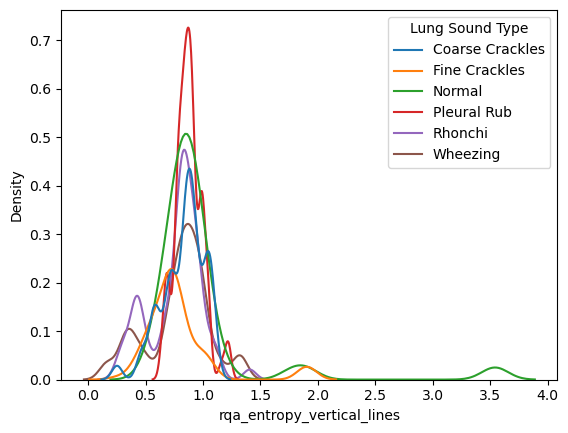

In [103]:
import seaborn as sns
sns.kdeplot(data=df_sem_cod_LS, x="rqa_entropy_vertical_lines",
            hue="Lung Sound Type")  # ou outro target

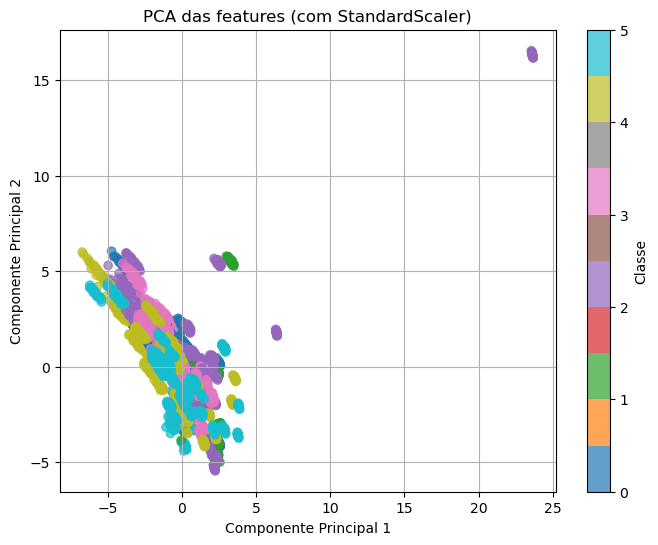

,count,mean,std,min,25%,50%,75%,max
auto_intersecoes,7483.0,419191.260724,3.381542e+05,3.985100e+04,153468.500000,322786.000000,544423.500000,1.279200e+06
rqa_longest_diagonal_line,7483.0,31.368702,1.894136e+02,4.000000e+00,9.000000,12.000000,15.000000,2.240000e+03
rqa_longest_vertical_line,7483.0,19.815849,1.162372e+02,3.000000e+00,7.000000,9.000000,10.000000,1.371000e+03
freq,7483.0,38.434398,9.328226e+00,2.200000e+01,32.200000,36.800000,42.600000,1.466000e+02
comprimento_curva,7483.0,13.229323,7.464190e+00,3.423200e-01,7.281401,12.510279,18.101608,4.731088e+01
rqa_trapping_time,7483.0,2.809036,4.290026e+00,2.038278e+00,2.329121,2.421669,2.506971,5.302041e+01
rqa_average_diagonal_line,7483.0,2.883271,2.821232e+00,2.161836e+00,2.489906,2.621617,2.772449,3.579014e+01
window_id,7483.0,2.022585,1.439188e+00,0.000000e+00,1.000000,2.000000,3.000000,4.000000e+00
entropia_raio,7483.0,2.103048,3.772698e-01,8.242482e-01,1.886737,2.167498,2.383236,2.674148e+00
rqa_entropy_vertical_lines,7483.0,0.849584,3.256285e-01,1.624308e-01,0.728062,0.840046,0.932252,3.541591e+00


In [113]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Seleção das features e rótulo
X = df_sem_cod_LS.drop(columns=[
    'Gender', 'Lung Sound Type', 'Location',
    'file_id', 'rqa_file_id', 'rqa_window_id', 'Lung Sound ID'
])
y = df_sem_cod_LS["Lung Sound Type"]

# 2. Padronização das features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Aplicação do PCA
X_pca = PCA(n_components=2).fit_transform(X_scaled)

# 4. Visualização com coloração por classe (usando códigos numéricos)
classes = y.astype('category').cat.codes  # transforma as classes em números
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=classes, cmap="tab10", alpha=0.7)
plt.title("PCA das features (com StandardScaler)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Classe")
plt.grid(True)
plt.show()

# 5. (Opcional) Ver quais variáveis têm maior variância original
X.describe().T.sort_values('std', ascending=False)

In [125]:
df_sem_cod_LS.columns

Index(['freq', 'centro_x', 'centro_y', 'raio_medio', 'raio_std', 'raio_max',
       'raio_min', 'simetria_x', 'simetria_y', 'densidade_nucleo',
       'comprimento_curva', 'variacao_curvatura', 'mudanca_media_direcao',
       'entropia_raio', 'auto_intersecoes', 'file_id', 'window_id',
       'rqa_recurrence_rate', 'rqa_determinism', 'rqa_average_diagonal_line',
       'rqa_longest_diagonal_line', 'rqa_entropy_diagonal_lines',
       'rqa_laminarity', 'rqa_trapping_time', 'rqa_longest_vertical_line',
       'rqa_entropy_vertical_lines', 'rqa_file_id', 'rqa_window_id', 'rqa_fs',
       'rqa_embedding_dim', 'rqa_delay', 'rqa_rqa_threshold', 'has_trapping',
       'Gender', 'Lung Sound Type', 'Location', 'Lung Sound ID'],
      dtype='object')

In [127]:
# Seleciona apenas colunas numéricas (float ou int)
numeric_cols = df_sem_cod_LS.select_dtypes(include=['float64', 'int']).columns

# Calcula a variância intra-áudio por file_id
variancia_intra_audio = df_sem_cod_LS.groupby('file_id')[numeric_cols].var()

# Exibe as primeiras linhas da tabela
display(variancia_intra_audio.head())

variancia_intra_audio.to_excel("teste.xlsx", index=False)

,freq,centro_x,centro_y,raio_medio,raio_std,raio_max,raio_min,simetria_x,simetria_y,densidade_nucleo,...,rqa_entropy_diagonal_lines,rqa_laminarity,rqa_trapping_time,rqa_entropy_vertical_lines,rqa_window_id,rqa_fs,rqa_embedding_dim,rqa_delay,rqa_rqa_threshold,has_trapping
file_id,,,,,,,,,,,,,,,,,,,,,
../../data/raw/HeartANDLung_Sounds_Dataset/LS/LS\F_CC_LLA.wav,30.639726,0.000005,0.000005,1.087857e-05,5.473975e-06,0.000926,4.708830e-08,1.015503e-05,1.042689e-05,0.011618,...,0.001782,0.000271,0.000306,0.000629,1.848756,0.0,0.0,0.0,0.0,0.0
../../data/raw/HeartANDLung_Sounds_Dataset/LS/LS\F_CC_LMA.wav,23.755679,0.000002,0.000002,1.078153e-06,3.248888e-06,0.001539,1.179230e-08,1.304040e-06,1.595264e-06,0.022223,...,0.000616,0.000572,0.010056,0.007461,1.909443,0.0,0.0,0.0,0.0,0.0
../../data/raw/HeartANDLung_Sounds_Dataset/LS/LS\F_CC_LUA.wav,17.265886,0.000001,0.000001,5.516095e-07,6.807049e-07,0.000173,7.953599e-09,7.115272e-07,9.113154e-07,0.011744,...,0.001096,0.000446,0.000912,0.000915,1.950725,0.0,0.0,0.0,0.0,0.0
../../data/raw/HeartANDLung_Sounds_Dataset/LS/LS\F_CC_RLA.wav,117.693232,0.000004,0.000004,5.872138e-05,4.072006e-05,0.001156,3.879104e-08,5.825948e-05,5.308381e-05,0.003935,...,0.014478,0.002960,0.009296,0.032216,1.606061,0.0,0.0,0.0,0.0,0.0
../../data/raw/HeartANDLung_Sounds_Dataset/LS/LS\F_CC_RMA.wav,38.754673,0.000010,0.000010,5.319502e-05,1.746575e-05,0.001976,6.117391e-08,4.697537e-05,4.781414e-05,0.021169,...,0.001065,0.000394,0.002655,0.003111,1.761430,0.0,0.0,0.0,0.0,0.0
